In [ ]:
from time import time
inicio = time()

In [ ]:
pip install keras-tuner

     |████████████████████████████████| 96 kB 3.7 MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-py3-none-any.whl size=9568 sha256=e64b9842ff5c6cde63d6470af6a9076633bbfa6b1ccdd5001da66a95cf066e2a
  Stored in directory: /root/.cache/pip/wheels/38/5c/e0/13003e68c17f403af40b92a24d20171b95fef13b0fdaba833c
Successfully built kt-legacy


In [ ]:
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import kerastuner as kt
from numpy import asarray
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tensorflow.keras import layers

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  


In [ ]:
# Guardarmos el dataset en un drive
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


# Cargamos el dataset

In [ ]:
# Cargamos el dataset desde https://github.com/aia-uclouvain/gti-mig-paper/tree/master/data (archivo "replication_bilateral.dta")
raw_dataset = pd.read_stata('/content/gdrive/MyDrive/Proyecto_ML/replication_bilateral.dta') 
raw_dataset.head(20)

,pair_id,iso3n_o,iso3n_d,year,source_country,iso3_o,iso3_d,log_mig,fwd_log_mig,o_log_pop,d_log_pop,o_log_gdp,d_log_gdp,GTI1,GTI2,GTI3,GTI4,GTI5,GTI6,GTI7,GTI8,GTI9,GTI10,GTI11,GTI12,GTI13,GTI14,GTI15,GTI16,GTI17,GTI18,GTI19,GTI20,GTI21,GTI22,GTI23,GTI24,GTI25,GTI26,GTI27,...,GTI_bil_49,GTI_bil_50,GTI_bil_51,GTI_bil_52,GTI_bil_53,GTI_bil_54,GTI_bil_55,GTI_bil_56,GTI_bil_57,GTI_bil_58,GTI_bil_59,GTI_bil_60,GTI_bil_61,GTI_bil_62,GTI_bil_63,GTI_bil_64,GTI_bil_65,GTI_bil_66,GTI_bil_67,o_sl_uem_totl_zs,o_sp_pop_0014_to_zs,sfi_sfi,pol4_autoc,o_IT_CEL_SETS_P2,o_IT_NET_USER_P2,o_number_weather,o_number_nonweather,mig_stock_tot,o_French,o_Spanish,o_English,log_mig_stock,d_GDP,d_pop,o_GDP,o_pop,tot_mig,fwd_tot_mig,iso3n_oXyear,iso3n_dXyear
0,171,32,36,2004,Argentina,ARG,AUS,5.950643,5.961005,3.656583,3.002082,5.318777,6.509861,0.000000,41.916668,49.333332,0.0,67.666664,71.333336,74.916664,8.083333,16.083334,80.833336,28.083334,48.666668,50.666668,58.750000,59.916668,54.333332,24.833334,62.250000,17.416666,11.583333,54.250000,65.000000,24.083334,30.750000,25.916666,24.500000,10.750000,...,0.0,0.0,0.0,41.833332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.333333,0.0,0.0,0.0,0.0,0.0,0.0,12.6,26.647324,4.0,0.0,35.272288,16.036684,3,0,NaN,0.0,0.99,0.0,NaN,671.733032,20.127401,204.133987,38.728775,384.000000,386.999939,64128,72144
1,171,32,36,2005,Argentina,ARG,AUS,5.961005,5.590987,3.667285,3.015280,5.406773,6.541519,6.666667,47.583332,48.083332,0.0,53.916668,59.083332,65.750000,13.333333,14.916667,67.916664,24.166666,29.166666,35.500000,55.416668,42.916668,48.250000,21.583334,43.166668,13.833333,10.250000,49.000000,58.500000,20.750000,29.583334,27.833334,23.916666,9.583333,...,0.0,0.0,0.0,35.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,10.6,26.321699,2.0,0.0,57.328994,17.720583,1,0,NaN,0.0,0.99,0.0,NaN,693.339050,20.394800,222.911011,39.145489,387.999939,267.000061,64160,72180
2,171,32,36,2006,Argentina,ARG,AUS,5.590987,5.164786,3.677787,3.030032,5.487457,6.570987,5.166667,43.750000,40.750000,0.0,60.916668,54.500000,61.583332,27.000000,12.250000,55.500000,19.000000,20.750000,27.500000,50.083332,41.000000,39.916668,15.916667,37.916668,15.833333,8.833333,40.166668,56.166668,25.750000,29.500000,30.833334,27.916666,7.083333,...,0.0,0.0,0.0,29.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,10.1,26.007032,2.0,0.0,80.818826,20.927202,1,0,NaN,0.0,0.99,0.0,NaN,714.074097,20.697899,241.641998,39.558746,268.000061,173.999985,64192,72216
3,171,32,36,2007,Argentina,ARG,AUS,5.164786,5.170484,3.688127,3.036279,5.564099,6.607898,3.500000,45.833332,29.666666,0.0,69.500000,47.833332,57.416668,7.583333,8.416667,45.166668,21.416666,18.833334,27.666666,47.000000,33.916668,38.500000,13.000000,27.250000,15.166667,9.166667,39.916668,48.416668,26.500000,24.333334,33.916668,32.583332,8.583333,...,0.0,0.0,0.0,23.666666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,8.5,25.702198,2.0,0.0,102.721528,25.946633,3,0,NaN,0.0,0.99,0.0,NaN,740.924133,20.827599,260.889984,39.969906,174.999985,175.000015,64224,72252
4,171,32,36,2008,Argentina,ARG,AUS,5.170484,5.087596,3.698381,3.056319,5.594384,6.644252,4.000000,48.416668,32.750000,0.0,70.666664,43.666668,54.500000,16.500000,13.083333,38.166668,15.666667,15.250000,23.500000,43.250000,30.833334,33.666668,8.833333,24.333334,14.666667,8.583333,41.916668,39.750000,25.666666,20.500000,39.833332,46.333332,5.500000,...,0.0,0.0,0.0,16.666666,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.833333,0.0,0.0,0.0,0.0,0.0,0.0,7.8,25.410353,2.0,0.0,117.221183,28.112623,1,1,NaN,0.0,0.99,0.0,NaN,768.354980,21.249199,268.911987,40.381863,176.000015,161.000015,64256,72288
5,171,32,36,2009,Argentina,ARG,AUS,5.087596,5.323010,3.708649,3.076930,5.594886,6.661422,4.250000,49.166668,35.833332,0.0,53.750000,36.750000,48.916668,14.583333,16.833334,31.750000,18.250000,10.916667,17.750000,43.583332,25.333334,25.000000,10.500000,19.583334,13.916667,8.250000,39.333332,38.833332,26.583334,21.333334,42.916668,48.166

In [ ]:
# Visualizamos su shape
raw_dataset.shape

(23947, 169)

# Preprocesamos el dataset

Filtramos los NaN

In [ ]:
# Quitamos las filas que contengan algún NaN en algunas de las columnas de interés
raw_dataset.dropna(axis=0, subset=['o_IT_NET_USER_P2', 'o_French', 'o_Spanish', 'o_English'], inplace=True)
raw_dataset.shape

(19446, 169)

Obtenemos las columnas de interés

In [ ]:
# Utilizamos la función proveída por Gonzalez P. y Golenvaux N. [1], para obtener el dataset desde el archivo "replication_bilateral.dta"
# Observación: es la única función no creada por nosotros mismos
def getDataLSTM(oldData, fixed_effects_origin = True, fixed_effects_dest = True, fixed_effects_year = True, use_log = False, normInTotal = False):
    data = oldData.copy()
    list_origins = list(dict.fromkeys(data['iso3_o']))
    list_dests = list(dict.fromkeys(data['iso3_d']))
    list_years = list(dict.fromkeys(data['year']))
    def addFixed_effects(row):
        Xfixed_effects = []
        if fixed_effects_origin:
            fx_o = [0.] * len(list_origins)
            fx_o[list_origins.index(row['iso3_o'])] = 1.
            Xfixed_effects += fx_o
        if fixed_effects_dest:
            fx_d = [0.] * len(list_dests)
            fx_d[list_dests.index(row['iso3_d'])] = 1.
            Xfixed_effects += fx_d
        if fixed_effects_year:
            fx_y = [0.] * len(list_years)
            fx_y[list_years.index(row['year'])] = 1.
            Xfixed_effects += fx_y
        return Xfixed_effects
    uniGTI_col = data.columns[13:80] # e.g. "visa"
    biGTI_col = data.columns[81:148] # e.g. "visa Australia"
    control_var_col = data.columns[161:165]
    if use_log: # logarithm base e
      control_var_col = data.columns[9:14]
    uniGTI = np.array(data[uniGTI_col]) * np.array(data['GTI_bil_0']).reshape((data.count()[0],1))
    biGTI = np.array(data[biGTI_col])
    control_var = np.array(data[control_var_col])
    language = data[['o_French','o_Spanish','o_English']].apply(max,axis=1)
    fixed_effects = list(data.apply(addFixed_effects, axis=1))
    GTI = np.hstack((biGTI,uniGTI))
    y = np.array(data['fwd_tot_mig']).reshape((len(data['fwd_tot_mig']),1))
    data['fwd_tot_mig'] = y.tolist()
    if normInTotal:
      y = MinMaxScaler(feature_range=(0, 1)).fit_transform(y)
      control_var = MinMaxScaler(feature_range=(0, 1)).fit_transform(control_var)
    if use_log:
      y = np.array(data['fwd_log_mig']).reshape((len(data['fwd_log_mig']),1))
    data['GTI'] = GTI.tolist()
    data['fixed_effects'] = fixed_effects
    data['control_var'] = control_var.tolist()
    data['y'] = y.tolist()
    data['language'] = language
    groupedData = data.groupby(['pair_id']).agg({'iso3_o':lambda x:x.tolist()[0], 'iso3_d':lambda x:x.tolist()[0], 'year':lambda x:x.tolist(), 'control_var':lambda x:x.tolist(), 'GTI':lambda x:x.tolist(), 'fixed_effects':lambda x:x.tolist(), 'y':lambda x:x.tolist(), 'fwd_tot_mig':lambda x:x.tolist(), 'language':lambda x:x.tolist(), 'o_IT_NET_USER_P2':lambda x:x.tolist()})
    groupedData.rename(columns={'iso3_o':'origin','iso3_d':'dest','fwd_tot_mig':'tot_mig','o_IT_NET_USER_P2':'internet'},inplace=True)
    return groupedData

In [ ]:
dataset = getDataLSTM(raw_dataset, fixed_effects_origin = True, fixed_effects_dest = True, fixed_effects_year = True, use_log = False, normInTotal = False)
dataset.head(50)

,origin,dest,year,control_var,GTI,fixed_effects,y,tot_mig,language,internet
pair_id,,,,,,,,,,
171,ARG,AUS,"[2004, 2005, 2006, 2007, 2008, 2009, 2010, 201...","[[671.7330322265625, 20.12740135192871, 204.13...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[386.99993896484375], [267.00006103515625], [...","[[386.99993896484375], [267.00006103515625], [...","[0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.9...","[16.03668411, 17.72058337, 20.9272021, 25.9466..."
172,ARG,AUT,"[2004, 2005, 2006, 2007, 2008, 2009, 2010, 201...","[[308.05401611328125, 8.171965599060059, 204.1...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[74.00000762939453], [50.0], [81.999984741210...","[[74.00000762939453], [50.0], [81.999984741210...","[0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.9...","[16.03668411, 17.72058337, 20.9272021, 25.9466..."
173,ARG,BEL,"[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]","[[409.04705810546875, 10.625699043273926, 260....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[114.00000762939453], [109.00000762939453], [...","[[114.00000762939453], [109.00000762939453], [...","[0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99]","[25.94663294, 28.11262348, 34.0, 45.0, 51.0, 5..."
174,ARG,CAN,"[2004, 2005, 2006, 2007, 2008, 2009, 2010, 201...","[[1128.449951171875, 31.99500274658203, 204.13...","[[0.0, 0.0, 0.0, 0.0, 0.0, 42.25, 0.0, 0.0, 0....","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1153.000244140625], [847.0001831054688], [62...","[[1153.000244140625], [847.0001831054688], [62...","[0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.9...","[16.03668411, 17.72058337, 20.9272021, 25.9466..."
175,ARG,CHE,"[2009, 2010, 2011, 2012, 2013]","[[441.8769836425781, 7.743830680847168, 269.04...","[[0.0, 0.0, 0.0, 0.0, 5.583333492279053, 0.0, ...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[239.00001525878906], [262.0], [221.999984741...","[[239.00001525878906], [262.0], [221.999984741...","[0.99, 0.99, 0.99, 0.99, 0.99]","[34.0, 45.0, 51.0, 55.8, 59.9]"
176,ARG,CHL,"[2004, 2005, 2006, 2007, 2008, 2009, 2010, 201...","[[117.85201263427734, 15.91312026977539, 204.1...","[[0.0, 12.583333015441895, 0.0, 0.0, 0.0, 63.2...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[4085.00048828125], [3516.99853515625], [3022...","[[4085.00048828125], [3516.99853515625], [3022...","[0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.9...","[16.03668411, 17.72058337, 20.9272021, 25.9466..."
177,ARG,CZE,"[2004, 2005, 2006, 2007, 2008, 2009, 2010, 201...","[[127.75999450683594, 10.197101593017578, 204....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[9.0], [10.000000953674316], [27.999998092651...","[[9.0], [10.000000953674316], [27.999998092651...","[0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.9...","[16.03668411, 17.72058337, 20.9272021, 25.9466..."
178,ARG,DEU,"[2004, 2005, 2006, 2007, 2008, 2009, 2010, 201...","[[2837.580322265625, 82.5162582397461, 204.133...","[[0.0, 0.0, 0.0, 0.0, 0.0, 34.0, 0.0, 0.0, 0.0...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[767.0], [885.0], [943.9999389648438], [911.0...","[[767.0], [885.0], [943.9999389648438], [911.0...","[0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.9...","[16.03668411, 17.72058337, 20.9272021, 25.9466..."
179,ARG,DNK,"[2004, 2005, 2006, 2007, 2008, 2009, 2010, 201...","[[258.2659606933594, 5.404522895812988, 204.13...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[26.000001907348633], [26.000001907348633], [...","[[26.000001907348633], [26.000001907348633], [...","[0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.99, 0.9...","[16.03668411, 17.72058337, 20.9272021, 25.9466..."


In [ ]:
# Visualizamos su shape
dataset.shape

(2117, 10)

Adaptamos las samples a 8 años (timesteps)

In [ ]:
# Debido a que las samples varían en cuanto a la cantidad de años (timesteps) que abarca cada una,
# eliminamos las samples que consideran menos de 8 años,
# mientras que las que consideran más, las acotamos a sólo 8 años.

In [ ]:
lenes=[]
for sample_year in dataset['year']:
  lenes.append(len(sample_year))
dataset['lens']=lenes
dataset=dataset.loc[dataset['lens']>=8]
dataset.drop(['lens'], axis=1, inplace=True)

i=0
for sample_year in dataset['year']:
  if len(sample_year) > 8:
    dataset['year'].array[i]=dataset['year'].array[i][0:8]
  i+=1
i=0
for sample_year in dataset['control_var']:
  if len(sample_year) > 8:
    dataset['control_var'].array[i]=dataset['control_var'].array[i][0:8]
  i+=1
i=0
for sample_year in dataset['GTI']:
  if len(sample_year) > 8:
    dataset['GTI'].array[i]=dataset['GTI'].array[i][0:8]
  i+=1
i=0
for sample_year in dataset['fixed_effects']:
  if len(sample_year) > 8:
    dataset['fixed_effects'].array[i]=dataset['fixed_effects'].array[i][0:8]
  i+=1
i=0
for sample_year in dataset['y']:
  if len(sample_year) > 8:
    dataset['y'].array[i]=dataset['y'].array[i][0:8]
  i+=1

i=0
for sample_year in dataset['tot_mig']:
  if len(sample_year) > 8:
    dataset['tot_mig'].array[i]=dataset['tot_mig'].array[i][0:8]
  i+=1 

i=0
for sample_year in dataset['language']:
  if len(sample_year) > 8:
    dataset['language'].array[i]=dataset['language'].array[i][0:8]
  i+=1 

i=0
for sample_year in dataset['internet']:
  if len(sample_year) > 8:
    dataset['internet'].array[i]=dataset['internet'].array[i][0:8]
  i+=1 

# Visualizamos el nuevo shape del dataset
dataset.shape

(1686, 10)

Normalizamos el dataset

In [ ]:
# Utilizamos la técnica MinMaxScaler para normalizar el dataset,
# quedando los valores en el rango [0, 1]

In [ ]:
def getNormalizedData(dataset):
  
  # control_var
  scaler_control_var = MinMaxScaler()
  aux = []
  for sample in dataset['control_var']:
    for year in sample:
      aux.append(year)
  aux = scaler_control_var.fit_transform(aux)
  samples = []
  for year in range(0,len(aux),8):
    samples.append(aux[year:year+8])
  dataset['control_var'] = samples

  # GTI
  scaler_GTI = MinMaxScaler()
  aux = []
  for sample in dataset['GTI']:
    for year in sample:
      aux.append(year)
  aux = scaler_GTI.fit_transform(aux)
  samples = []
  for year in range(0,len(aux),8):
    samples.append(aux[year:year+8])
  dataset['GTI'] = samples

  # y
  scaler_y = MinMaxScaler()
  aux = []
  for sample in dataset['y']:
    for year in sample:
      aux.append(year)
  aux = scaler_y.fit_transform(aux)
  samples = []
  for year in range(0,len(aux),8):
    samples.append(aux[year:year+8])
  dataset['y'] = samples

  # internet
  scaler_internet = MinMaxScaler()
  aux = []
  for sample in dataset['internet']:
    for year in sample:
      aux.append(year)
  aux = scaler_internet.fit_transform(asarray(aux).reshape(-1, 1))
  samples = []
  for year in range(0,len(aux),8):
    samples.append(aux[year:year+8])
  dataset['internet'] = samples

  # language
  scaler_language = MinMaxScaler()
  aux = []
  for sample in dataset['language']:
    for year in sample:
      aux.append(year)
  aux = scaler_language.fit_transform(asarray(aux).reshape(-1, 1))
  samples = []
  for year in range(0,len(aux),8):
    samples.append(aux[year:year+8])
  dataset['language'] = samples

  return dataset, scaler_y

In [ ]:
normalized_dataset, scaler = getNormalizedData(dataset)
normalized_dataset.head(20)

,origin,dest,year,control_var,GTI,fixed_effects,y,tot_mig,language,internet
pair_id,,,,,,,,,,
171,ARG,AUS,"[2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]","[[0.04773479171408926, 0.06369120659848518, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0020369592107036764], [0.00140534449446880...","[[386.99993896484375], [267.00006103515625], [...","[[0.99], [0.99], [0.99], [0.99], [0.99], [0.99...","[[0.16661486000525377], [0.1843196027954705], ..."
172,ARG,AUT,"[2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]","[[0.021389277132965036, 0.025302320203822892, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0003894961780511566], [0.00026317306614468...","[[74.00000762939453], [50.0], [81.999984741210...","[[0.99], [0.99], [0.99], [0.99], [0.99], [0.99...","[[0.16661486000525377], [0.1843196027954705], ..."
173,ARG,BEL,"[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]","[[0.028705381561625526, 0.03318125463832124, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0006000346309669044], [0.00057371732435243...","[[114.00000762939453], [109.00000762939453], [...","[[0.99], [0.99], [0.99], [0.99], [0.99], [0.99...","[[0.27080939186778297], [0.29358290707007756],..."
174,ARG,CAN,"[2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]","[[0.08082012717312469, 0.1017980569997486, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.4980353485276693,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0060687721903211695], [0.00445815270425951...","[[1153.000244140625], [847.0001831054688], [62...","[[0.99], [0.99], [0.99], [0.99], [0.99], [0.99...","[[0.16661486000525377], [0.1843196027954705], ..."
176,ARG,CHL,"[2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]","[[0.007610726724507362, 0.05015915632092507, 0...","[[0.0, 0.18898622079837418, 0.0, 0.0, 0.0, 0.7...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.021501242074070226], [0.01851158576246871]...","[[4085.00048828125], [3516.99853515625], [3022...","[[0.99], [0.99], [0.99], [0.99], [0.99], [0.99...","[[0.16661486000525377], [0.1843196027954705], ..."
177,ARG,CZE,"[2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]","[[0.008328477458884896, 0.03180502886395037, 0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[4.737115190604327e-05], [5.263461824856484e-...","[[9.0], [10.000000953674316], [27.999998092651...","[[0.99], [0.99], [0.99], [0.99], [0.99], [0.99...","[[0.16661486000525377], [0.1843196027954705], ..."
178,ARG,DEU,"[2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]","[[0.20463238225981087, 0.26402173313613864, 0....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.40078584260214806...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0040370748346594655], [0.00465816327076092...","[[767.0], [885.0], [943.9999389648438], [911.0...","[[0.99], [0.99], [0.99], [0.99], [0.99], [0.99...","[[0.16661486000525377], [0.1843196027954705], ..."
179,ARG,DNK,"[2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]","[[0.017782547346765886, 0.016416065805843524, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.00013685000443449188], [0.0001368500044344...","[[26.000001907348633], [26.000001907348633], [...","[[0.99], [0.99], [0.99], [0.99], [0.99], [0.99...","[[0.16661486000525377], [0.1843196027954705], ..."
180,ARG,ESP,"[2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]","[[0.07989937871534036, 0.13688428877467151, 0....","[[0.0, 0.3441802025870579, 0.0, 0.0, 0.4893617...","[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.12979171332163145], [0.1273284442631109], ...","[[24659.00390625], [24191.009765625], [21462.0...","[[0.99], [0.99], [0.99], [0.99], [0.99], [0.99...","[[0.16661486000525377], [0.1843196027954705], ..."


# Dividimos en set de entrenamiento y testeo

In [ ]:
X, y = normalized_dataset[['control_var','GTI','language','internet']], normalized_dataset['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (1348, 4)
X_test shape: (338, 4)
y_train shape: (1348,)
y_test shape: (338,)


Función para graficar el proceso de entrenamiento

In [ ]:
# Función para graficar el proceso de entrenamiento
def train_results(train_loss, val_loss, name=None):
  fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize = ((7, 7)))
  ax = axs
  ax.set_title('Loss', fontsize = 25)
  ax.grid(color = 'black', alpha = 0.5, linestyle = 'dashed', linewidth = 0.5)
  ax.plot(train_loss, label = 'loss_train', color = 'black', linestyle = '-')
  ax.plot(val_loss, label = 'loss_val', color = 'orange')
  ax.set_xlabel('Epochs', fontsize = 13)
  ax.legend()
  plt.savefig(name)

Función para obtener las métricas

In [ ]:
# Con la finalidad de evaluar la calidad de las predicciones, usaremos las métricas:
# Mean Squared Error
# Root Mean Squared Error
# Coeficiente de determinación (R2)
# Coeficiente de determinación ajustado (R2 ajustado)

In [ ]:
def get_original_values(y, scaler): # Función para retornar los valores entre 0 y 1 a sus valores originales
  aux = []
  for sample in y:
    for year in sample:
      aux.append(year)
  aux = scaler.inverse_transform(asarray(aux).reshape(-1,1)) # se usa la transformación inversa del MinMaxScaler
  samples = []
  for year in range(0,len(aux),8):
    samples.append(aux[year:year+8])
  y_original = samples
  return asarray(y_original)

def get_R2(y_test, y_pred):
  # ajustamos el formato de y_test, para usar la función r2_score
  y_test_aux = []
  for sample in y_test:
    aux_test = []
    for year in sample:
      aux_test.append(int(year))
    y_test_aux.append(aux_test)
  y_pred_aux = []
 # ajustamos el formato de y_pred, para usar la función r2_score
  for sample in y_pred:
    aux_pred = []
    for year in sample:
      aux_pred.append(int(year))
    y_pred_aux.append(aux_pred)
  # calculamos el R2, para regresión con multi-output
  R2 = r2_score(y_test_aux, y_pred_aux, multioutput='variance_weighted')
  return R2

def evaluate_prediction(y_true, y_pred):
  # Mean Squared Error
  MSE = 0
  for y_t, y_p in zip(y_true, y_pred):
    MSE_partial = mean_squared_error(y_t, y_p)
    MSE += MSE_partial
  # Root Mean Squared Error
  RMSE = np.sqrt(MSE)
  # R2
  R2 = get_R2(y_true, y_pred)
  # R2_ajustado
  n = y_true.shape[0] # cantidad de samples
  p = 140 # cantidad de features 
  R2_ajustado = 1- (1-R2) * (n-1) / (n-p-1)
  return MSE, RMSE, R2, R2_ajustado

# Modificamos el shape del dataset

In [ ]:
# Un último ajuste antes de utilizar el dataset es descomponer la columna "control_var" en sus cuatro componentes:
  # Población del país de origen en el año t,
  # Población del país de destino en el año t,
  # PIB del país de origen en el año t,
  # PIB del país de destino en el año t.
# Procedemos análogamente con la columna "GTI", descomponiendola en sus 134 GTI index.

In [ ]:
X_train=X_train.to_numpy()
X_test=X_test.to_numpy()
y_train=y_train.to_numpy()
y_test=y_test.to_numpy()

cosita_train=[]
for i in range(y_train.shape[0]):
  lili=np.concatenate(y_train[i],axis=None)
  cosita_train.append(lili)
y_train=np.array(cosita_train)

cosita_test=[]
for i in range(y_test.shape[0]):
  lili=np.concatenate(y_test[i],axis=None)
  cosita_test.append(lili)
y_test=np.array(cosita_test)

nina_train=[]

for j in range(X_train.shape[0]):
  lala=[]
  for i in range(8):
    lala.append(np.concatenate((X_train[j][0][i], X_train[j][1][i],X_train[j][2][i],X_train[j][3][i]), axis=None))
  
  lala=np.array(lala)
  nina_train.append(lala)
X_train=np.array(nina_train)

nina_test=[]

for j in range(X_test.shape[0]):
  lala=[]
  for i in range(8):
    lala.append(np.concatenate((X_test[j][0][i], X_test[j][1][i],X_test[j][2][i],X_test[j][3][i]), axis=None))
  
  lala=np.array(lala)
  nina_test.append(lala)
X_test=np.array(nina_test)

# Visualizamos el nuevo shape
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (1348, 8, 140)
X_test shape: (338, 8, 140)
y_train shape: (1348, 8)
y_test shape: (338, 8)


# Creamos un tuner personalizado

In [ ]:
# Creamos una subclase que hereda de kerastuner.tuners.BayesianOptimization, y sobre-cargamos el método run_trial.
# Esto se hace para incluir la hiperoptimización del batch size.
class MyTuner(kt.tuners.BayesianOptimization):
  def run_trial(self, trial, *args, **kwargs):
    kwargs['batch_size'] = trial.hyperparameters.Choice('batch_size', values=[16, 32, 64])
    super(MyTuner, self).run_trial(trial, *args, **kwargs)

# LSTM Neural Network

Hacemos optimización de hiperparámetros

In [ ]:
def lstm_builder(hp):  # hp es un objeto que representa nuestros hiperparametros a optimizar
  
  # Definimos el modelo
  model_lstm = tf.keras.Sequential()

  # Hiperparámetros a optimizar
  hp_l1_factor = hp.Choice('l1_regularization_factor', values=[1e-2, 1e-3]) # L1 regularization factor
  hp_l2_factor = hp.Choice('l2_regularization_factor', values=[1e-2, 1e-3]) # L2 regularization factor
  hp_embedding_dim = hp.Choice('embedding_dimension', values=[32, 64, 128]) # embedding dimension
  hp_LSTM_layers = hp.Choice('LSTM_layers', values=[2, 3]) # cantidad de capas LSTM
  hp_Dense_layers = hp.Choice('Dense_layers', values=[2, 3]) # cantidad de capas Dense
  hp_LSTM_units = hp.Choice('LSTM_units', values=[32, 64, 128]) # cantidad de neuronas en las capas Dense
  hp_Dense_neurons = hp.Choice('Dense_neurons', values=[32, 64, 128]) # cantidad de units en las capas LSTM
  hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop']) # optimizer
  hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0001]) # learning rate

  # input layer
  model_lstm.add(layers.InputLayer(input_shape=(8,140), 
                                  dtype=tf.float64, 
                                  name='Input_layer'))
  
  layer_id = 1 # índice de las layers

  # embedding layer
  model_lstm.add(layers.Dense(hp_embedding_dim,
                              name = 'Embedding_layer_{}'.format(layer_id)))
  
  # se añaden capas tipo LSTM
  for lstm_layer in range(hp_LSTM_layers-1):
    layer_id += 1
    model_lstm.add(layers.LSTM(hp_LSTM_units,
                              return_sequences=True, 
                              kernel_regularizer=tf.keras.regularizers.L1L2(l1=hp_l1_factor, l2=hp_l2_factor),
                              name='LSTM_layer_{}'.format(layer_id)))
  layer_id += 1
  model_lstm.add(layers.LSTM(hp_LSTM_units,
                             kernel_regularizer=tf.keras.regularizers.L1L2(l1=hp_l1_factor, l2=hp_l2_factor), 
                             name='LSTM_layer_{}'.format(layer_id))) 
    
  # se añaden capas tipo Dense
  for dense_layer in range(hp_Dense_layers):
    layer_id += 1
    model_lstm.add(layers.Dense(hp_Dense_neurons, 
                                activation='relu',
                                kernel_regularizer=tf.keras.regularizers.L1L2(l1=hp_l1_factor, l2=hp_l2_factor),
                                name='Dense_layer_{}'.format(layer_id)))

  # output layer
  model_lstm.add(layers.Dense(8, 
                              activation='relu',
                              name='Output_layer')) # recordar que se usó MinMaxScaler en [0,1] para el y

  # se compila el modelo
  if hp_optimizer == 'adam':
      model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                         loss='mse')
  else: # cuando hp_optimizer == 'rmsprop'
      model_lstm.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
                         loss='mse')

  return model_lstm

# Ejecutamos el tuner
tuner_lstm = MyTuner(lstm_builder,
                      objective='val_loss',
                      max_trials=50,  
                      directory='hyperparameters-tuning-LSTM',          
                      project_name='hp-tuning-LSTM')

callbacks_lstm = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15),
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-8)]
# history_lstm = model_lstm.fit(X_train, y_train, validation_split=0.2, batch_size=100, epochs=80, shuffle=True, callbacks=callbacks_lstm)
tuner_lstm.search(X_train, y_train, validation_split=0.2, epochs=40, shuffle=True, callbacks=callbacks_lstm, verbose=1)

Trial 50 Complete [00h 00m 26s]
val_loss: 0.0006468946230597794

Best val_loss So Far: 0.00039460835978388786
Total elapsed time: 00h 40m 19s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Obtenemos la combinación de hiperparámetros más prometedora, encontrada en el proceso de hiperoptimización.
best_hps_lstm = tuner_lstm.get_best_hyperparameters(num_trials=1)

# Imprimos la combinación de hiperparámetros obtenida.
print('Hiperparámetros: \n',
      'batch_size: ', best_hps_lstm[0].get('batch_size'), '\n',
      'l1_regularization_factor: ', best_hps_lstm[0].get('l1_regularization_factor'), '\n',
      'l2_regularization_factor: ', best_hps_lstm[0].get('l2_regularization_factor'), '\n',
      'embedding_dimension: ', best_hps_lstm[0].get('embedding_dimension'), '\n',
      'LSTM_layers: ', best_hps_lstm[0].get('LSTM_layers'), '\n',
      'Dense_layers: ', best_hps_lstm[0].get('Dense_layers'), '\n',
      'LSTM_units: ', best_hps_lstm[0].get('LSTM_units'), '\n',
      'Dense_neurons: ', best_hps_lstm[0].get('Dense_neurons'), '\n',
      'optimizer: ', best_hps_lstm[0].get('optimizer'), '\n',
      'learning_rate: ', best_hps_lstm[0].get('learning_rate') )

Hiperparámetros: 
 batch_size:  16 
 l1_regularization_factor:  0.001 
 l2_regularization_factor:  0.001 
 embedding_dimension:  32 
 LSTM_layers:  2 
 Dense_layers:  3 
 LSTM_units:  32 
 Dense_neurons:  32 
 optimizer:  rmsprop 
 learning_rate:  0.001


In [ ]:
control_lstm_1 = time()

Hacemos 3-Fold Cross-Validation

In [ ]:
kf = KFold(n_splits=3, shuffle=True, random_state=0) # objeto que se utilizará para hacer el 3-fold cross-validation

# listas para guardar las métricas
MSE_lstm = []
RMSE_lstm = []
R2_lstm = []
R2_adjusted_lstm = []

# diccionario para guardar los modelos de cada fold
modelos_lstm = {}

max_epochs = 50 
callbacks_lstm = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15),   
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-8)] 

fold = 1 # contador de folds
for train_index, val_index in kf.split(X_train):
  print('Inicio del entrenamiento del fold {}'.format(fold))

  # dividimos sets de entrenamiento y validación, en cada fold
  train_fold, val_fold = X_train[train_index], X_train[val_index]
  y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

  # construimos el modelo
  modelos_lstm['fold_{}'.format(fold)] = tuner_lstm.hypermodel.build(best_hps_lstm[0])

  # lo entrenamos con los datos del fold actual
  modelos_lstm['history_fold_{}'.format(fold)] = modelos_lstm['fold_{}'.format(fold)].fit(train_fold, y_train_fold, 
                                                                                          epochs=max_epochs, 
                                                                                          validation_data=(val_fold, y_val_fold), 
                                                                                          verbose=0,
                                                                                          batch_size=best_hps_lstm[0].get('batch_size'),
                                                                                          callbacks=callbacks_lstm)
  
  # utilizamos X_test para hacer las predicciones, para evaluar el modelo en el fold actual
  y_pred = modelos_lstm['fold_{}'.format(fold)].predict(X_test)

  # primero hay que convertir tanto y_test como y_pred a sus valores originales, luego evaluamos la calidad de las predicciones
  MSE, RMSE, R2, R2_adjusted = evaluate_prediction(get_original_values(y_test, scaler), get_original_values(y_pred, scaler))
  MSE_lstm.append(MSE)
  RMSE_lstm.append(RMSE)
  R2_lstm.append(R2)
  R2_adjusted_lstm.append(R2_adjusted)

  fold += 1

print('\n')
print('Métricas promedio')
print('MSE_lstm: ', np.mean(MSE_lstm))
print('RMSE_lstm: ', np.mean(RMSE_lstm))
print('R2_lstm: ', np.mean(R2_lstm))
print('R2_adjusted_lstm: ', np.mean(R2_adjusted_lstm))

Inicio del entrenamiento del fold 1
Inicio del entrenamiento del fold 2
Inicio del entrenamiento del fold 3


Métricas promedio
MSE_lstm:  3653297884.1432343
RMSE_lstm:  60442.4481636188
R2_lstm:  -0.017244791743944315
R2_adjusted_lstm:  -0.7401598721711128


Obtenemos un esquema del modelo LSTM

Summary
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_layer_1 (Dense)    (None, 8, 32)             4512      
_________________________________________________________________
LSTM_layer_2 (LSTM)          (None, 8, 32)             8320      
_________________________________________________________________
LSTM_layer_3 (LSTM)          (None, 32)                8320      
_________________________________________________________________
Dense_layer_4 (Dense)        (None, 32)                1056      
_________________________________________________________________
Dense_layer_5 (Dense)        (None, 32)                1056      
_________________________________________________________________
Dense_layer_6 (Dense)        (None, 32)                1056      
_________________________________________________________________
Output_layer (Dense)         (None, 8)          

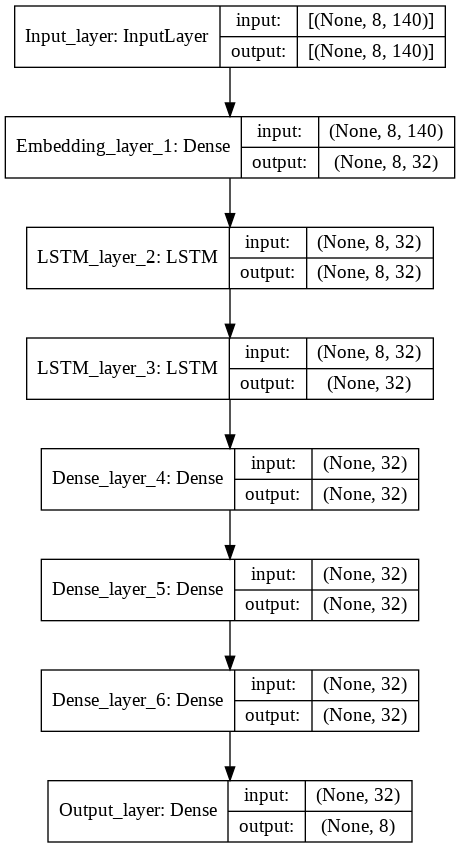

In [ ]:
print('Summary')
modelos_lstm['fold_1'].summary()
print('\n\n Esquema')
tf.keras.utils.plot_model( modelos_lstm['fold_1'], 'Esquema_LSTM.png', show_shapes=True)

Graficamos el entrenamiento en cada fold

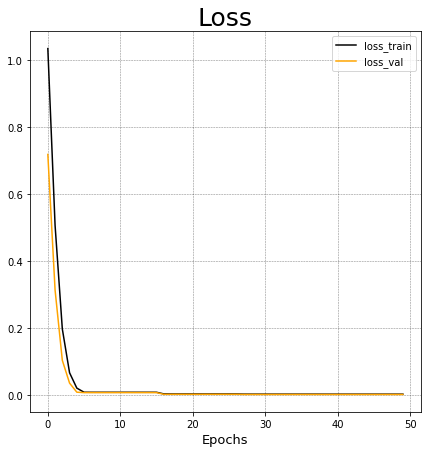

In [ ]:
# En el fold 1
train_results(train_loss=modelos_lstm['history_fold_1'].history['loss'],      
              val_loss=modelos_lstm['history_fold_1'].history['val_loss'],
              name='LSTM_fold_1.png')

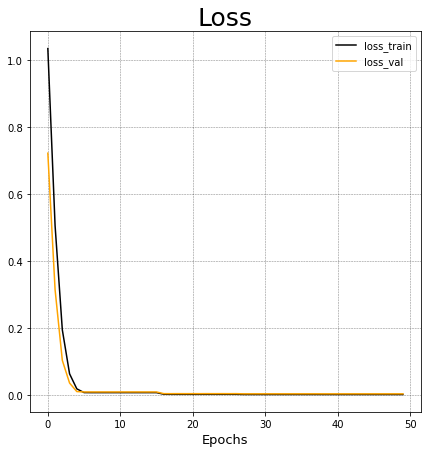

In [ ]:
# En el fold 2
train_results(train_loss=modelos_lstm['history_fold_2'].history['loss'],      
              val_loss=modelos_lstm['history_fold_2'].history['val_loss'],
              name='LSTM_fold_2.png')

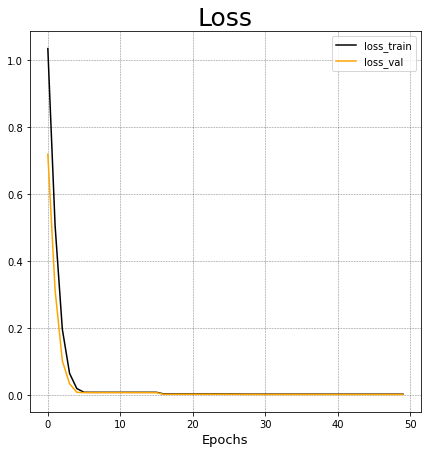

In [ ]:
# En el fold 3
train_results(train_loss=modelos_lstm['history_fold_3'].history['loss'],      
              val_loss=modelos_lstm['history_fold_3'].history['val_loss'],
              name='LSTM_fold_3.png')

In [ ]:
control_lstm_2 = time()

# Convolutional Neural Network

Hacemos reshape al X_train y X_test

In [ ]:
X_train_cnn = X_train.reshape(X_train.shape + (1,))
X_test_cnn = X_test.reshape(X_test.shape + (1,))
print('X_train_cnn shape: ',X_train_cnn.shape)
print('X_test_cnn shape: ',X_test_cnn.shape)

# Definimos y entrenamos el modelo
input_shape_cnn = X_train_cnn.shape[1:]

X_train_cnn shape:  (1348, 8, 140, 1)
X_test_cnn shape:  (338, 8, 140, 1)


Hacemos optimización de hiperparámetros

In [ ]:
def cnn_builder(hp):
  model = tf.keras.models.Sequential()

  hp_l1_factor = hp.Choice('l1_regularization_factor', values=[1e-2, 1e-3]) # L1 regularization factor
  hp_l2_factor = hp.Choice('l2_regularization_factor', values=[1e-2, 1e-3]) # L2 regularization factor
  hp_Dense_layers = hp.Choice('Dense_layers', values=[2, 3]) # cantidad de capas Dense
  hp_CNN_filters = hp.Choice('CNN_filters', values=[16,32, 64, 128]) # cantidad de neuronas en las capas Dense
  hp_Dense_neurons = hp.Choice('Dense_neurons', values=[32, 64, 128]) # cantidad de units en las capas 
  hp_optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop']) # optimizer
  hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0001]) # learning rate

  model.add(layers.InputLayer( input_shape=( 8,140, 1), 
                                      dtype=tf.float64, 
                                      name='Input_layer')) 
  model.add(tf.keras.layers.Conv2D(hp_CNN_filters, (3, 3),padding='valid', activation='relu',
                                    kernel_regularizer=tf.keras.regularizers.L1L2(l1=hp_l1_factor, l2=hp_l2_factor),
                                   name='Conv2D_layer_1'))
  model.add(tf.keras.layers.BatchNormalization(name='BatchNormalization_layer_2'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2), name='MaxPooling2D_layer_3'))
  model.add(tf.keras.layers.Conv2D(hp_CNN_filters, (3, 3),padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L1L2(l1=hp_l1_factor, l2=hp_l2_factor), name='Conv2D_layer_4'))
  model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2,2), name='MaxPooling2D_layer_5'))
  model.add(tf.keras.layers.Conv2D(hp_CNN_filters, (3, 3),padding='same', activation='relu',kernel_regularizer=tf.keras.regularizers.L1L2(l1=hp_l1_factor, l2=hp_l2_factor), name='Conv2D_layer_6'))

  # Capas fully connected
  model.add(tf.keras.layers.Flatten(name='Flatten_layer_7'))

  id_layer = 7
  for dense_layer in range(hp_Dense_layers):
    id_layer += 1
    model.add(layers.Dense(hp_Dense_neurons,activation='elu',kernel_regularizer=tf.keras.regularizers.L1L2(l1=hp_l1_factor, l2=hp_l2_factor), name='Dense_layer_{}'.format(id_layer)))
    id_layer += 1
    model.add(tf.keras.layers.Dropout(0.5, name='Dropout_layer_{}'.format(id_layer)))
  
  model.add(tf.keras.layers.Dense(8, name='Output_layer'))

  if hp_optimizer == 'adam':
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                         loss='mse')
  else: # cuando hp_optimizer == 'rmsprop'
      model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=hp_learning_rate),
                         loss='mse')

  return model

# Ejecutamos el tuner
tuner_cnn = MyTuner(cnn_builder,
                      objective='val_loss',
                      max_trials=50,  
                      directory='hyperparameters-tuning-cnn',          
                      project_name='hp-tuning-cnn')

callbacks_cnn = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15),
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-8)] 
tuner_cnn.search(X_train_cnn, y_train, validation_split=0.2, epochs=40, shuffle=True, callbacks=callbacks_cnn, verbose=1)

Trial 40 Complete [00h 01m 23s]
val_loss: 0.010899970307946205

Best val_loss So Far: 0.0003948934900108725
Total elapsed time: 02h 03m 04s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Obtenemos la combinación de hiperparámetros más prometedora, encontrada en el proceso de hiperoptimización.
best_hps_cnn = tuner_cnn.get_best_hyperparameters(num_trials=1)

# Imprimos la combinación de hiperparámetros obtenida.
print('Hiperparámetros: \n',
      'batch_size: ', best_hps_cnn[0].get('batch_size'), '\n',
      'l1_regularization_factor: ', best_hps_cnn[0].get('l1_regularization_factor'), '\n',
      'l2_regularization_factor: ', best_hps_cnn[0].get('l2_regularization_factor'), '\n',
      'Dense_layers: ', best_hps_cnn[0].get('Dense_layers'), '\n',
      'CNN_filters: ', best_hps_cnn[0].get('CNN_filters'), '\n',
      'Dense_neurons: ', best_hps_cnn[0].get('Dense_neurons'), '\n',
      'optimizer: ', best_hps_cnn[0].get('optimizer'), '\n',
      'learning_rate: ', best_hps_cnn[0].get('learning_rate') )

Hiperparámetros: 
 batch_size:  16 
 l1_regularization_factor:  0.001 
 l2_regularization_factor:  0.001 
 Dense_layers:  2 
 CNN_filters:  16 
 Dense_neurons:  32 
 optimizer:  rmsprop 
 learning_rate:  0.001


In [ ]:
control_cnn_1 = time()

Hacemos 3-Fold Cross-Validation

In [ ]:
kf = KFold(n_splits=3, shuffle=True, random_state=0) # objeto que se utilizará para hacer el 3-fold cross-validation

# listas para guardar las métricas
MSE_cnn = []
RMSE_cnn = []
R2_cnn = []
R2_adjusted_cnn = []

# diccionario para guardar los modelos de cada fold
modelos_cnn = {}

max_epochs = 50 
callbacks_cnn = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20),   
                  tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=15, min_lr=1e-8)] 

fold = 1 # contador de folds
for train_index, val_index in kf.split(X_train):
  print('Inicio del entrenamiento del fold {}'.format(fold))

  # dividimos sets de entrenamiento y validación, en cada fold
  train_fold, val_fold = X_train_cnn[train_index], X_train_cnn[val_index]
  y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

  # construimos el modelo
  modelos_cnn['fold_{}'.format(fold)] = tuner_cnn.hypermodel.build(best_hps_cnn[0])

  # lo entrenamos con los datos del fold actual
  modelos_cnn['history_fold_{}'.format(fold)] = modelos_cnn['fold_{}'.format(fold)].fit(train_fold, y_train_fold, 
                                                                                          epochs=max_epochs, 
                                                                                          validation_data=(val_fold, y_val_fold), 
                                                                                          verbose=0,
                                                                                          batch_size=best_hps_cnn[0].get('batch_size'),
                                                                                          callbacks=callbacks_cnn)
  
  # utilizamos X_test para hacer las predicciones, para evaluar el modelo en el fold actual
  y_pred = modelos_cnn['fold_{}'.format(fold)].predict(X_test_cnn)
  # modelos_lstm['predicted_values_fold_{}'.format(i)] = modelos_lstm['fold_{}'.format(fold)].predict(X_test) ##################### borrar

  # primero hay que convertir tanto y_test como y_pred a sus valores originales, luego evaluamos la calidad de las predicciones
  MSE, RMSE, R2, R2_adjusted = evaluate_prediction(get_original_values(y_test, scaler), get_original_values(y_pred, scaler))
  MSE_cnn.append(MSE)
  RMSE_cnn.append(RMSE)
  R2_cnn.append(R2)
  R2_adjusted_cnn.append(R2_adjusted)

  fold += 1

print('\n')
print('Métricas promedio')
print('MSE_cnn: ', np.mean(MSE_cnn))
print('RMSE_cnn: ', np.mean(RMSE_cnn))
print('R2_cnn: ', np.mean(R2_cnn))
print('R2_adjusted_cnn: ', np.mean(R2_adjusted_cnn))

Obtenemos un esquema del modelo CNN

Summary
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D_layer_1 (Conv2D)      (None, 6, 138, 16)        160       
_________________________________________________________________
BatchNormalization_layer_2 ( (None, 6, 138, 16)        64        
_________________________________________________________________
MaxPooling2D_layer_3 (MaxPoo (None, 3, 69, 16)         0         
_________________________________________________________________
Conv2D_layer_4 (Conv2D)      (None, 3, 69, 16)         2320      
_________________________________________________________________
MaxPooling2D_layer_5 (MaxPoo (None, 1, 34, 16)         0         
_________________________________________________________________
Conv2D_layer_6 (Conv2D)      (None, 1, 34, 16)         2320      
_________________________________________________________________
Flatten_layer_7 (Flatten)    (None, 544)        

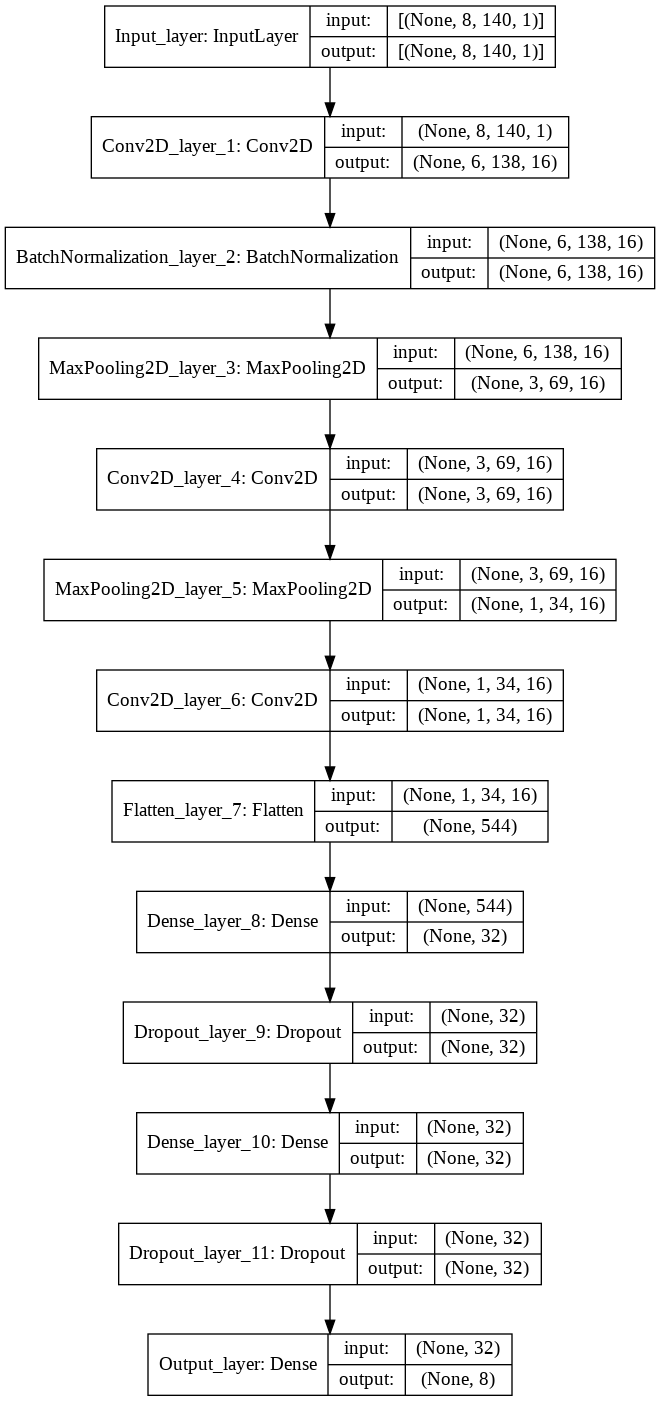

In [ ]:
print('Summary')
modelos_cnn['fold_1'].summary()
print('\n\n Esquema')
tf.keras.utils.plot_model( modelos_cnn['fold_1'], './Esquema_CNN.png', show_shapes=True)

Graficamos el entrenamiento en cada fold

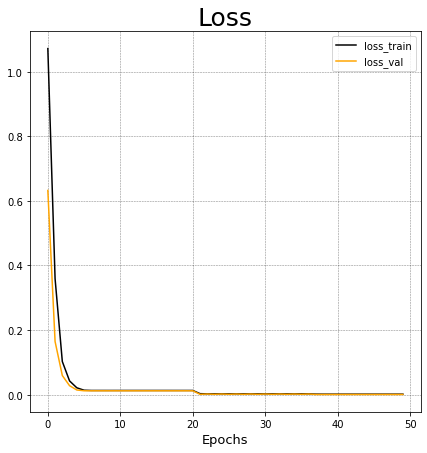

In [ ]:
# En el fold 1
train_results(train_loss=modelos_cnn['history_fold_1'].history['loss'],      
              val_loss=modelos_cnn['history_fold_1'].history['val_loss'],
              name='CNN_fold_1.png')

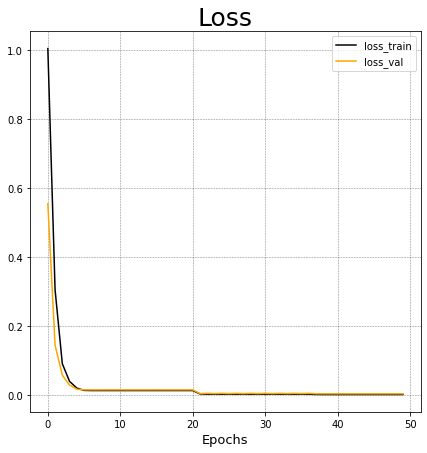

In [ ]:
# En el fold 2
train_results(train_loss=modelos_cnn['history_fold_2'].history['loss'],      
              val_loss=modelos_cnn['history_fold_2'].history['val_loss'],
              name='CNN_fold_2.png')

In [ ]:
# En el fold 3
train_results(train_loss=modelos_cnn['history_fold_3'].history['loss'],      
              val_loss=modelos_cnn['history_fold_3'].history['val_loss'],
              name='CNN_fold_3.png')

In [ ]:
control_cnn_2 = time()

# Referencias

[1] Gonzalez P. y Golenvaux N., (2020), "An LSTM approach to predict migration based on Google Trends", Ecole polytechnique de Louvain, Université catholique de Louvain, 2020. Prom.: Schaus P., Kiossou, H.

In [ ]:
# tiempos

tiempo_lstm_hp = control_lstm_1 - inicio
tiempo_lstm_fold = control_lstm_2 - control_lstm_1 
tiempo_cnn_hp = control_cnn_1 - control_lstm_2
tiempo_cnn_fold = control_cnn_2 - control_cnn_1 

print('tiempo_lstm_hp: ', tiempo_lstm_hp)
print('tiempo_lstm_fold: ', tiempo_lstm_fold)
print('tiempo_cnn_hp: ', tiempo_cnn_hp)
print('tiempo_cnn_fold: ', tiempo_cnn_fold)